<a href="https://colab.research.google.com/github/Risuo/Springboard/blob/master/Capstone_Prototype_Kaggle_Kernel_v_0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import numpy as np

#test = np.ones((10000 * 1000000, 100))

In [0]:
%whos

Interactive namespace is empty.


## We begin by getting some data and attempting to get some rudimentary interactions: 
1) view an image
2) view data on an image
3) import and modify a Kaggle-Grand-Master provided kernel to get it running
4) tbd

#View an image:
## First step is to get our data loaded in a place where we won't have to download it again. Initially I attempted to utilize Kaggle's API, however, there were some fundamental issues that seemed to be too time-intensive to bother fixing (example: the Kaggle API requires a kaggle.json file located in a /.kaggle folder. The leading period doesn't play well with Colab's interaction with a mounted Google Drive, so instead I simply manually downloaded the data to my desktop, and imported it into my Google Drive. (This took about 2 hours, start to finish. Definitely won't be taking this route again without looking into alternatives first...)

##

#Viewing an image was successful, so at the very least at this stage, the data is properly loaded. Next hurdle was to actually get the training step to successfully compile and run. 
## That took extensive troubleshooting and debugging, while also becoming familiar with the layout and function of all of the imported pre-written modules. 
## That being said, the training runs, and after dealing with memory issues, after being run for 250 epochs, we have metrics that implied things were doing pretty good (Jacard scores in the 70 percentiles).  However, we ran into issues in that after 117 the scores all dropped precipitously. This will have to be investigated in the future. 
## The next step was to work on getting the mask presentation (via polygon interpretation) to be properly reflected after training the model. 

## We're taking a slight detour here and moving away from the 16 band dataset, and jumping over to the 3 band (rgb) dataset first. If we can get this to work, we'll see about incorporating the 16 band dataset. This is based off of minor debugging within mask creation and the apparent mis-match between the mask data and the specific tiff images within the 16 band dataset. I suspect this rests in my ignorance of the details of the datasets, but given the age of this project on Kaggle, this seems like a wise next step. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
"""
The first step is to prototype using a ready-made kernel provided by Kaggle user n01z3, at this link:
https://www.kaggle.com/drn01z3/end-to-end-baseline-with-u-net-keras
The steps will be to break it down into more managable jupyter notebook segments for testing & debugging. 
"""

In [0]:
!pip install tifffile

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf


tf.keras.backend.clear_session()
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
tf.keras.backend.clear_session()

In [0]:
%whos

Variable           Type        Data/Info
----------------------------------------
absolute_import    _Feature    _Feature((2, 5, 0, 'alpha<...>0, 0, 'alpha', 0), 16384)
division           _Feature    _Feature((2, 2, 0, 'alpha<...> 0, 0, 'alpha', 0), 8192)
print_function     _Feature    _Feature((2, 6, 0, 'alpha<...>0, 0, 'alpha', 0), 65536)
tf                 module      <module 'tensorflow' from<...>/tensorflow/__init__.py'>
unicode_literals   _Feature    _Feature((2, 6, 0, 'alpha<...>, 0, 'alpha', 0), 131072)


In [0]:
import tifffile as tiff

%ls '/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/three_band'


In [0]:
from collections import defaultdict
import csv
import sys

import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff

csv.field_size_limit(sys.maxsize);

In [0]:
#img_path = '/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/three_band/6120_2_2.tif'
img_path = '/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/three_band/6110_0_1.tif'

IM_ID = '6120_2_2'
#IM_ID = '6120_2_2'
POLY_TYPE = '1'  # buildings

# Load grid size
x_max = y_min = None
for _im_id, _x, _y in csv.reader(open('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/grid_sizes.csv')):
    if _im_id == IM_ID:
        x_max, y_min = float(_x), float(_y)
        print(x_max, y_min, 'here')
        break

# Load train poly with shapely
train_polygons = None
for _im_id, _poly_type, _poly in csv.reader(open('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/train_wkt_v4.csv')):
    if _im_id == IM_ID and _poly_type == POLY_TYPE:
        train_polygons = shapely.wkt.loads(_poly)
        break

# Read image with tiff
im_rgb = tiff.imread('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0])
im_size = im_rgb.shape[:2]

0.009188 -0.00904 here


In [0]:
def get_scalers_testing():
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    print(h, w)
    w_ = w * (w / (w + 1))
    print(w_)
    h_ = h * (h / (h + 1))
    print(h_)
    return w_ / x_max, h_ / y_min

x_scaler, y_scaler = get_scalers_testing()

train_polygons_scaled = shapely.affinity.scale(
    train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))

3348 3403
3402.000293772033
3347.0002985965957


In [0]:
def mask_for_polygons_testing(polygons):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

train_mask = mask_for_polygons_testing(train_polygons_scaled)

In [0]:
def scale_percentile_testing(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

In [0]:
tiff.imshow(255 * scale_percentile(im_rgb[2900:3200,2000:2300]));

In [0]:
def show_mask_testing(m):
    # hack for nice display
    tiff.imshow(255 * np.stack([m, m, m]));
show_mask_testing(train_mask)

In [0]:

P = tiff.imread('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/three_band/6120_2_2.tif') 
print(P.shape)
tiff.imshow(P)

In [0]:
__author__ = "n01z3" # Original author. Extensive editing has been done, at least, in bringing the code up to Tensorflow 2.x
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
from keras.callbacks import ModelCheckpoint
import shapely.wkt
import shapely.affinity
from collections import defaultdict

Using TensorFlow backend.


In [0]:
%whos

In [0]:
N_Cls = 10
inDir = '/content/drive/My Drive/Capstone/Kaggle/Kaggle Data'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
ISZ = 160
smooth = 1e-12

In [0]:
print('Train_wkt_v4: The Well-Known-Text format of the training labels. Shape:', DF.shape)
print('Grid_sizes: The size of grids for all of the images. Shape:', GS.shape)
print('Sample_submission: Contains [[Image ID], [ClassType (int 1-10)], [Multipolygon WKT geometry]]. Shape:', SB.shape)

Train_wkt_v4: The Well-Known-Text format of the training labels. Shape: (250, 3)
Grid_sizes: The size of grids for all of the images. Shape: (450, 3)
Sample_submission: Contains [[Image ID], [ClassType (int 1-10)], [Multipolygon WKT geometry]]. Shape: (4290, 3)


In [0]:
DF.head # WKT format of training labels

<bound method NDFrame.head of       ImageId  ClassType                                    MultipolygonWKT
0    6040_2_2          1                                 MULTIPOLYGON EMPTY
1    6040_2_2          2                                 MULTIPOLYGON EMPTY
2    6040_2_2          3                                 MULTIPOLYGON EMPTY
3    6040_2_2          4  MULTIPOLYGON (((0.003025 -0.007879000000000001...
4    6040_2_2          5  MULTIPOLYGON (((0.005311 -0.009044999999999999...
..        ...        ...                                                ...
245  6100_2_2          6  MULTIPOLYGON (((0.006102 -0.009042, 0.00642 -0...
246  6100_2_2          7  MULTIPOLYGON (((0.007887999999999999 -0.009042...
247  6100_2_2          8  MULTIPOLYGON (((0.002119 -0.001417, 0.002132 -...
248  6100_2_2          9  MULTIPOLYGON (((0.008021 -0.003252, 0.00803399...
249  6100_2_2         10  MULTIPOLYGON (((0.003194 -0.0089, 0.003201 -0....

[250 rows x 3 columns]>

In [0]:
GS.head # The size of grids for all of the images

<bound method NDFrame.head of       ImageId      Xmax      Ymin
0    6120_2_4  0.009180 -0.009040
1    6120_2_3  0.009169 -0.009040
2    6120_2_2  0.009188 -0.009040
3    6120_2_1  0.009188 -0.009040
4    6120_2_0  0.009188 -0.009040
..        ...       ...       ...
445  6130_1_4  0.009169 -0.009040
446  6130_1_3  0.009188 -0.009040
447  6130_1_2  0.009150 -0.009042
448  6130_1_1  0.009004 -0.009045
449  6130_1_0  0.009188 -0.009040

[450 rows x 3 columns]>

In [0]:
SB.head # [[Image ID], [ClassType (int 1-10)], [Multipolygon WKT geometry]]

<bound method NDFrame.head of        ImageId  ClassType                                    MultipolygonWKT
0     6120_2_4          1  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
1     6120_2_4          2  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
2     6120_2_4          3  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
3     6120_2_4          4  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4     6120_2_4          5  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
...        ...        ...                                                ...
4285  6130_1_0          6  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4286  6130_1_0          7  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4287  6130_1_0          8  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4288  6130_1_0          9  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4289  6130_1_0         10  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...

[4290 rows x 3 columns]>

In [0]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

In [0]:
def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)

In [0]:
def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList

In [0]:
def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList

In [0]:
def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list

In [0]:
def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask

In [0]:
def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask

In [0]:
def RGB(image_id):
  filename = os.path.join(inDir, 'three_band', '{}.tif'.format(image_id))
  img = tiff.imread(filename)
  # img has the shape (bands, width, height)
  img = np.rollaxis(img, 0, 3)
  return img

In [0]:
a = np.ones((3, 160, 160))
print(a.shape)
a = np.rollaxis(a, 0, 3)
print(a.shape)

(3, 160, 160)
(160, 160, 3)


In [0]:
#def M(image_id):
#    # __author__ = amaia
#    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
#    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
#    img = tiff.imread(filename)
#    img = np.rollaxis(img, 0, 3)
#    return img

In [0]:
def stretch_n(bands, lower_percent=5, higher_percent=95):
    out = np.zeros_like(bands).astype(np.float32) # added .astype(np.float32) per comment within thread 
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

In [0]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2]) # Orig
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2]) # Orig
    
    #intersection = K.sum(y_true * y_pred, axis = [0, -2, -3]) # Modified
    #sum_ = K.sum(y_true + y_pred, axis = [0, -2, -3]) # Modified

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)



In [0]:
def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2]) # Orig
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2]) # added _pos to y_pred again per thread, Orig

    #intersection = K.sum(y_true * y_pred_pos, axis = [0, -2, -3]) # Modified
    #sum_ = K.sum(y_true, y_pred_pos, axis = [0, -2, -3]) # Modified)

    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [0]:
def stick_all_train():
    print("let's stick all imgs together")
    s = 835

    x = np.zeros((5 * s, 5 * s, 3))
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(DF.ImageId.unique())
    print('Length of ids here:', len(ids))
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = RGB(id)
            img = stretch_n(img)
            print('Post-stretching of img here:', img.shape, id, np.amax(img), np.amin(img))
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print('amax(y), amin(y):', np.amax(y), np.amin(y))

    np.save('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/x_trn_3_band_%d' % N_Cls, x)
    np.save('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/y_trn_3_band_%d' % N_Cls, y)

In [0]:
def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x = 2 * np.transpose(x, (0, 1, 2, 3)) - 1
    y = np.transpose(y, (0, 1, 2, 3))

    print('get_patches result:', x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y))
    return x, y

In [0]:
def make_val():
    print("let's pick some samples for validation")
    img = np.load('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/x_trn_3_band_%d.npy' % N_Cls)
    msk = np.load('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/y_trn_3_band_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=3000)

    np.save('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/x_tmp_3_band_%d' % N_Cls, x)
    np.save('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/y_tmp_3_band_%d' % N_Cls, y)

In [0]:
"""
from tf.keras.models import Model
from tf.keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from tf.keras.optimizers import Adam
"""

'\nfrom tf.keras.models import Model\nfrom tf.keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout\nfrom tf.keras.optimizers import Adam\n'

We encountered the first issue where the dimensions of our model were entering negative territory on the pool4 line. I made an initial change to the input shape from 8 to 16. Not sure yet how that will affect things, but at least the model compiles now. 

* Needed to change input dimension from 8 to 16 (still not sure if will work)
* Needed to split up merge([UpSampling2D...]) layer into two new layers, first an UpSampling2D layer, second a Concatenate layer
* Needed to change concatenation axis from 1 to -1
* 

In [0]:
from tensorflow import keras
from tensorflow.keras import layers
import pdb

In [0]:
# __author__ = Peter Miller
def get_model():
  input_size = (ISZ, ISZ, 3)
  inputs = keras.Input(input_size)

  print(inputs.shape)

  conv1 = layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(inputs)
  print('conv1a', conv1.shape)
  conv1 = layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(conv1)
  print('conv1b', conv1.shape)
  pool1 = layers.MaxPool2D(pool_size = (2, 2))(conv1)
  print('pool1', pool1.shape)

  conv2 = layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(pool1)
  print('conv2a', conv2.shape)
  conv2 = layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(conv2)
  print('conv2b', conv2.shape)
  pool2 = layers.MaxPool2D(pool_size = (2, 2))(conv2)
  print('pool2', pool2.shape)

  conv3 = layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(pool2)
  print('conv3a', conv3.shape)
  conv3 = layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(conv3)
  print('conv3a', conv3.shape)
  pool3 = layers.MaxPool2D(pool_size = (2, 2))(conv3)
  print('pool3', pool3.shape)

  conv4 = layers.Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(pool3)
  print('conv4a', conv4.shape)
  conv4 = layers.Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(conv4)
  print('conv4b', conv4.shape)
  pool4 = layers.MaxPool2D(pool_size = (2, 2))(conv4)
  print('pool4', pool4.shape)

  conv5 = layers.Conv2D(512, (3, 3), padding ='same', activation = 'relu')(pool4)
  print('conv5a', conv5.shape)
  conv5 = layers.Conv2D(512, (3, 3), padding ='same', activation = 'relu')(conv5)
  print('conv5b', conv5.shape)

  up6 = layers.UpSampling2D(size = (2,2))(conv5)
  print('up6', up6.shape)
  concat1 = layers.Concatenate(axis = -1)([up6, conv4]) 
  print('concat1', concat1.shape)

  """ I believe the following a) and b) lines properly mimick the implementation the c) line:
      a) up6 = layers.UpSampling2D(size = (2,2))(conv5)
      b) concat1 = layers.Concatenate(axis = 1)([up6, conv4]) 

      c) up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)"""

  conv6 = layers.Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(concat1)
  print('conv6a', conv6.shape)
  conv6 = layers.Conv2D(256, (3, 3), padding ='same', activation = 'relu')(conv6)
  print('conv6b', conv6.shape)

  up7 = layers.UpSampling2D(size = (2,2))(conv6)
  print('up7', up7.shape)
  concat2 = layers.Concatenate(axis = -1)([up7, conv3]) 
  print('concat2', concat2.shape)

  #up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
  conv7 = layers.Conv2D(128, (3, 3), padding ='same', activation = 'relu')(concat2)
  print('conv7a', conv7.shape)
  conv7 = layers.Conv2D(128, (3, 3), padding ='same', activation = 'relu')(conv7)
  print('conv7b', conv7.shape)

  up8 = layers.UpSampling2D(size = (2,2))(conv7)
  print('up8', up8.shape)
  concat3 = layers.Concatenate(axis = -1)([up8, conv2]) 
  print('concat3', concat3.shape)

  #up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)

  conv8 = layers.Conv2D(64, (3, 3), padding ='same', activation = 'relu')(concat3)
  print('conv8a', conv8.shape)
  conv8 = layers.Conv2D(64, (3, 3), padding ='same', activation = 'relu')(conv8)
  print('conv8b', conv8.shape)

  up9 = layers.UpSampling2D(size = (2,2))(conv8)
  print('up9', up9.shape)
  concat4 = layers.Concatenate(axis = -1)([up9, conv1]) 
  print('concat4', concat4.shape)

  #up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)

  conv9 = layers.Conv2D(32, (3, 3), padding ='same', activation = 'relu')(concat4)
  print('conv9a', conv9.shape)
  conv9 = layers.Conv2D(32, (3, 3), padding ='same', activation = 'relu')(conv9)
  print('conv9b', conv9.shape)

  outputs = layers.Conv2D(N_Cls, (1, 1), activation='sigmoid')(conv9)
  print('outputs', outputs.shape)

  model = keras.Model(inputs = inputs, outputs = outputs, name = 'unet_model')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, ), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
  return model

In [0]:
model = get_model()

(None, 160, 160, 3)
conv1a (None, 160, 160, 32)
conv1b (None, 160, 160, 32)
pool1 (None, 80, 80, 32)
conv2a (None, 80, 80, 64)
conv2b (None, 80, 80, 64)
pool2 (None, 40, 40, 64)
conv3a (None, 40, 40, 128)
conv3a (None, 40, 40, 128)
pool3 (None, 20, 20, 128)
conv4a (None, 20, 20, 256)
conv4b (None, 20, 20, 256)
pool4 (None, 10, 10, 256)
conv5a (None, 10, 10, 512)
conv5b (None, 10, 10, 512)
up6 (None, 20, 20, 512)
concat1 (None, 20, 20, 768)
conv6a (None, 20, 20, 256)
conv6b (None, 20, 20, 256)
up7 (None, 40, 40, 256)
concat2 (None, 40, 40, 384)
conv7a (None, 40, 40, 128)
conv7b (None, 40, 40, 128)
up8 (None, 80, 80, 128)
concat3 (None, 80, 80, 192)
conv8a (None, 80, 80, 64)
conv8b (None, 80, 80, 64)
up9 (None, 160, 160, 64)
concat4 (None, 160, 160, 96)
conv9a (None, 160, 160, 32)
conv9b (None, 160, 160, 32)
outputs (None, 160, 160, 10)


In [0]:
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 8) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 160, 160, 32) 2336        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 160, 160, 32) 9248        conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 80, 80, 32)   0           conv2d_11[0][0]                  
_________________________________________________________________________________________

In [0]:
def calc_jacc(x_val, y_val, model):
    x_val = x_val# = np.load('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/x_tmp_%d.npy' % N_Cls)
    y_val = y_val#= np.load('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/y_tmp_%d.npy' % N_Cls)
    print('x_val, y_val, loaded within calc_jacc')

    prd = model.predict(x_val, batch_size=4)
    print('x_val.shape & y_val.shape within calc_jacc', x_val.shape, y_val.shape)
    avg, trs = [], []

    for i in range(N_Cls):
        #t_msk = msk[:, i, :, :] Orig
        #t_prd = prd[:, i, :, :] Orig
        t_msk = y_val[:, :, :, i] # modified
        t_prd = prd[:, :, :, i] # modified
        #t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3]) Orig
        #t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3]) Orig
        t_msk = t_msk.reshape(y_val.shape[0] * y_val.shape[1], y_val.shape[2]) # modified
        t_prd = t_prd.reshape(y_val.shape[0] * y_val.shape[1], y_val.shape[2]) # modified

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        print('i, m, b_tr, within calc_jacc', i, '-:-', m, '-:-', b_tr)
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs

In [0]:
def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    print('img_mask within mask for polygons', img_mask.shape)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

In [0]:
def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    # image, (remove from original) 
    contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

In [0]:
def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

In [0]:
def train_net():
    print("start train net")
    x_val = np.load('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/x_tmp_3_band_%d.npy' % N_Cls)
    print('x_val initial shape:', x_val.shape)
    #x_val = x_val[:200]
    #print('x_val loaded, shape now:', x_val.shape)
    y_val = np.load('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/y_tmp_3_band_%d.npy' % N_Cls)
    print('y_val initial shape:', y_val.shape)
    #y_val = y_val[:200]
    #print('y_val loaded, shape now:', y_val.shape)

    img = np.load('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/x_trn_3_band_%d.npy' % N_Cls)
    print('img initial shape:', img.shape)
    #img = img[:200]
    #print('img loaded, shape now:', img.shape)
    msk = np.load('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/data/y_trn_3_band_%d.npy' % N_Cls)
    print('msk initial shape', msk.shape)
    #msk = msk[:200]
    #print('msk loaded, shape now:', msk.shape)

    x_trn, y_trn = get_patches(img, msk)
    print('x_trn, y_trn loaded, initial shapes:', x_trn.shape, y_trn.shape)
    #x_trn = x_trn[:2000]
    #y_trn = y_trn[:2000]
    #print('x_trn, y_trn post-shrinkage:', x_trn.shape, y_trn.shape)

    del img
    del msk

    model = get_model()
    #model.load_weights('weights/unet_10_jk0.7878')
    model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    #for i in range(10):
    history = model.fit(x_trn, y_trn, batch_size=128, epochs=150, verbose=1, shuffle=True,
              callbacks=[model_checkpoint], validation_data=(x_val, y_val)) #validation_split = .3) 
    #del x_trn
    #del y_trn
    #x_trn, y_trn = get_patches(img, msk)
    #print('x_trn, y_trn loaded within fit')
    score, trs = calc_jacc(x_val, y_val, model)
    print('val jk', score)
    model.save_weights('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/weights/unet_10_jk%.4f' % score)

    return history, model, x_val, y_val


In [0]:
def predict_id(id, model, trs):
    img = RGB(id)
    print(img.shape, 'img shape')
    x = stretch_n(img)
    print(x.shape, 'x shape')

    cnv = np.zeros((3650, 3650, 3)).astype(np.float32)
    #prd = np.zeros((N_Cls, 960, 960)).astype(np.float32) # Orig
    prd = np.zeros((960, 960, N_Cls)).astype(np.float32) # Modified
    print(cnv.shape, img.shape, img.shape[0], img.shape[1], x.shape)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        #x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1 # Orig
        x = 2 * np.transpose(line, (0, 1, 2, 3)) - 1 # Modified
        
        tmp = model.predict(x, batch_size=4)
        print(tmp.shape, 'tmp shape')
        for j in range(tmp.shape[0]):
            prd[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ, :] = tmp[j]

    #trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    #return prd[:, :img.shape[0], :img.shape[1]] # Orig
    return prd[:img.shape[0], :img.shape[1], :] # Modified

In [0]:
def predict_test(model, trs):
    print("predict test")
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save('/content/drive/My Drive/Capstone/Kaggle/Kaggle Data/msk/10_%s' % id, msk)
        if i % 100 == 0: print(i, id)

In [0]:
def check_predict(model, id='6120_2_2'):
    model = model
   #model.load_weights('weights/unet_10_jk0.7878')

    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    print('msk shape:', msk.shape)
    #msk = np.transpose(msk, (2, 0, 1)) # Possibly fixed by modifying the return output from predict_id
    #print('msk transposed:', msk.shape)
    img = RGB(id)
    print('img shape:', img.shape[:2])
    plt.figure()
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 1], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[2], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygons')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()

(3348, 3403, 3) img shape
(3348, 3403, 3) x shape
(3650, 3650, 3) (3348, 3403, 3) 3348 3403 (3348, 3403, 3)
(6, 160, 160, 10) tmp shape
(6, 160, 160, 10) tmp shape
(6, 160, 160, 10) tmp shape
(6, 160, 160, 10) tmp shape
(6, 160, 160, 10) tmp shape
(6, 160, 160, 10) tmp shape
msk shape: (960, 960, 10)
img shape: (3348, 3403)
img_mask within mask for polygons (3348, 3403)


<Figure size 432x288 with 0 Axes>

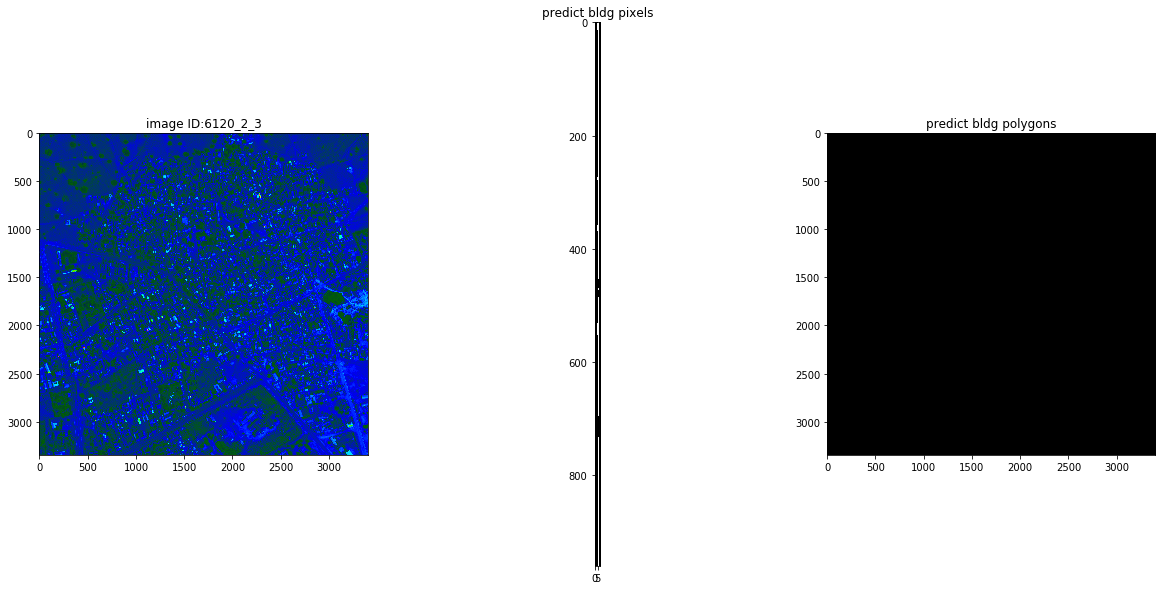

In [0]:
check_predict(model)

In [0]:
%whos

In [0]:
stick_all_train()


let's stick all imgs together
Length of ids here: 25
Post-stretching of img here: (3349, 3396, 3) 6010_1_2 1.0 0.0
Post-stretching of img here: (3345, 3396, 3) 6010_4_2 1.0 0.0
Post-stretching of img here: (3345, 3393, 3) 6010_4_4 1.0 0.0
Post-stretching of img here: (3349, 3391, 3) 6040_1_0 1.0 0.0
Post-stretching of img here: (3349, 3391, 3) 6040_1_3 1.0 0.0
Post-stretching of img here: (3349, 3391, 3) 6040_2_2 1.0 0.0
Post-stretching of img here: (3346, 3387, 3) 6040_4_4 1.0 0.0
Post-stretching of img here: (3348, 3403, 3) 6060_2_3 1.0 0.0
Post-stretching of img here: (3350, 3338, 3) 6070_2_3 1.0 0.0
Post-stretching of img here: (3349, 3393, 3) 6090_2_0 1.0 0.0
Post-stretching of img here: (3349, 3391, 3) 6100_1_3 1.0 0.0
Post-stretching of img here: (3349, 3391, 3) 6100_2_2 1.0 0.0
Post-stretching of img here: (3349, 3391, 3) 6100_2_3 1.0 0.0
Post-stretching of img here: (3348, 3396, 3) 6110_1_2 1.0 0.0
Post-stretching of img here: (3348, 3396, 3) 6110_3_1 1.0 0.0
Post-stretching o

In [0]:
make_val()

let's pick some samples for validation
get_patches result: (1138, 160, 160, 3) (1138, 160, 160, 10) 1.0 -1.0 1.0 0.0


In [0]:
history, model, x_val, y_val = train_net()

In [0]:
%whos

In [0]:


score, trs = calc_jacc(x_val, y_val, model)


x_val, y_val, loaded within calc_jacc
x_val.shape & y_val.shape within calc_jacc (1138, 160, 160, 3) (1138, 160, 160, 10)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


i, m, b_tr, within calc_jacc 0 -:- 0.8959310282442624 -:- 0.4
i, m, b_tr, within calc_jacc 1 -:- 0.7877863912043634 -:- 0.4
i, m, b_tr, within calc_jacc 2 -:- 0.9875198611954216 -:- 0.4
i, m, b_tr, within calc_jacc 3 -:- 0.8273619667708654 -:- 0.4
i, m, b_tr, within calc_jacc 4 -:- 0.8289043075026186 -:- 0.5
i, m, b_tr, within calc_jacc 5 -:- 0.9657760386026245 -:- 0.9
i, m, b_tr, within calc_jacc 6 -:- 0.9958781984660556 -:- 0.7
i, m, b_tr, within calc_jacc 7 -:- 0.9973707652675896 -:- 0.2
i, m, b_tr, within calc_jacc 8 -:- 0.9935779132680901 -:- 0.3
i, m, b_tr, within calc_jacc 9 -:- 0.9674652560460457 -:- 0.3


In [0]:
predict_test(model, trs)


In [0]:
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 8) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 32) 2336        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 80, 80, 32)   0           conv2d_1[0][0]                   
_________________________________________________________________________________________

(3348, 3403, 3) img shape
(3348, 3403, 3) x shape
(3650, 3650, 3) (3348, 3403, 3) 3348 3403 (3348, 3403, 3)
(6, 160, 160, 10) tmp shape
(6, 160, 160, 10) tmp shape
(6, 160, 160, 10) tmp shape
(6, 160, 160, 10) tmp shape
(6, 160, 160, 10) tmp shape
(6, 160, 160, 10) tmp shape
msk shape: (960, 960, 10)
img shape: (3348, 3403)


IndexError: ignored

<Figure size 432x288 with 0 Axes>

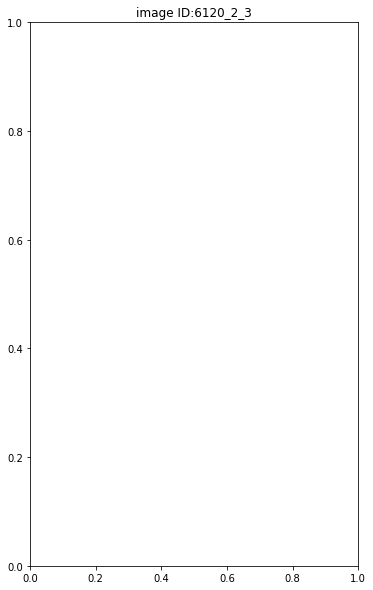

In [0]:
check_predict(model)

In [0]:




def make_submit():
    print "make submission file"
    df = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
    print df.head()
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1

        msk = np.load('msk/10_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print idx
    print df.head()
    df.to_csv('subm/1.csv', index=False)


if __name__ == '__main__':
    stick_all_train()
    make_val()
    model = train_net()
    score, trs = calc_jacc(model)
    predict_test(model, trs)
    make_submit()

    # bonus
    check_predict()